In [1]:
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Load GPX file
gpx_file = open("Manhattan_Loop.gpx", "r")  # Replace with your GPX file path
gpx = gpxpy.parse(gpx_file)

In [25]:
#Extract elevation and distance
distance = 0
distances = []
elevations = []

for track in gpx.tracks:
    for segment in track.segments:
        prev_point=None
        for point in segment.points:
            if prev_point:
                distance += point.distance_3d(prev_point) / 1000 #Convert to km
            distances.append(distance)
            elevations.append(point.elevation)
            prev_point = point

In [27]:
# Convert to DataFrame
df = pd.DataFrame({"Distance (km)": distances, "Elevation (m)": elevations})

# Save to CSV for backup
df.to_csv("elevation_data.csv", index=False)

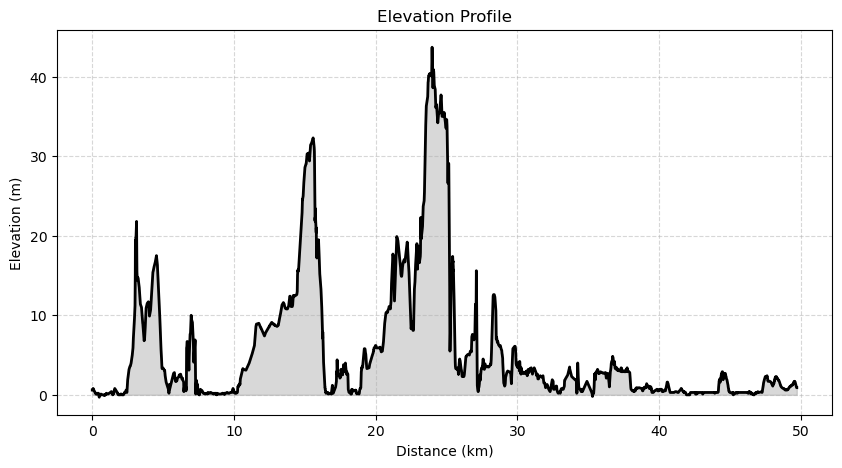

In [29]:
#Plot
plt.figure(figsize=(10, 5))
plt.plot(df["Distance (km)"], df["Elevation (m)"], color="black", linewidth=2)
plt.fill_between(df["Distance (km)"], df["Elevation (m)"], color="gray", alpha=0.3)
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Elevation Profile")
plt.grid(True, linestyle="--", alpha=0.5)
# plt.savefig("elevation_profile.svg", format="svg")  # Export to SVG for Figma
plt.show()

In [31]:
df.head()

,Distance (km),Elevation (m)
0,0.000000,0.6
1,0.009523,0.6
2,0.023018,0.6
3,0.024505,0.6
4,0.025618,0.6


In [107]:
import pandas as pd
import re

# Load CSV
file_path = "ManhattanPOI.csv" 
POI_df = pd.read_csv(file_path)

# Show cleaned data
POI_df.head()


,WKT,name,description
0,POINT (-73.9987172 40.7645602),Intrepid Museum,NaN
1,POINT (-74.0036345 40.705493),Restroom,NaN
2,POINT (-74.0035333 40.7057003),South Street Seaport,NaN
3,POINT (-74.0158905 40.7044284),Restroom,NaN
4,POINT (-74.0151815 40.7020193),TheBattery,NaN


In [109]:
# Extract latitude and longitude using regex
POI_df[['Longitude', 'Latitude']] = POI_df['WKT'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')

# Convert to float
POI_df['Longitude'] = POI_df['Longitude'].astype(float)
POI_df['Latitude'] = POI_df['Latitude'].astype(float)

POI_df.head()

,WKT,name,description,Longitude,Latitude
0,POINT (-73.9987172 40.7645602),Intrepid Museum,NaN,-73.998717,40.764560
1,POINT (-74.0036345 40.705493),Restroom,NaN,-74.003635,40.705493
2,POINT (-74.0035333 40.7057003),South Street Seaport,NaN,-74.003533,40.705700
3,POINT (-74.0158905 40.7044284),Restroom,NaN,-74.015890,40.704428
4,POINT (-74.0151815 40.7020193),TheBattery,NaN,-74.015181,40.702019


In [111]:
POI_df = POI_df.drop(['WKT', 'description'], axis=1)

In [113]:
POI_df

,name,Longitude,Latitude
0,Intrepid Museum,-73.998717,40.764560
1,Restroom,-74.003635,40.705493
2,South Street Seaport,-74.003533,40.705700
3,Restroom,-74.015890,40.704428
4,TheBattery,-74.015181,40.702019
5,GeorgeWashingtonBridge,-73.946527,40.848568
6,Restroom,-73.946294,40.847264
7,JohnFinleyWalk,-73.944528,40.772972
8,Riverside Park,-73.965312,40.813797
9,Restroom,-73.994609,40.771958


In [115]:
POI_df.to_csv("cleaned_poi.csv", index=False)

In [156]:

file_path = "cleaned_poi.csv"  # Adjust path if needed
poi_df = pd.read_csv(file_path)

# Separate Restrooms and Other POIs
restroom_df = poi_df[poi_df["name"].str.contains("Restroom", na=False)]
poi_only_df = poi_df[~poi_df["name"].str.contains("Restroom", na=False)]

# Save to separate CSVs
restroom_df.to_csv("restrooms.csv", index=False)
poi_only_df.to_csv("poi_only.csv", index=False)

print("CSV files created: restrooms.csv and poi_only.csv")


CSV files created: restrooms.csv and poi_only.csv


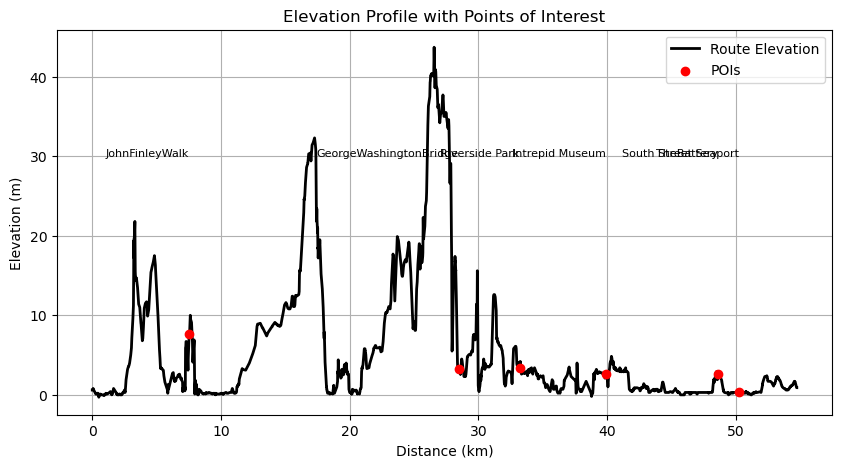

In [158]:
import pandas as pd
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

# Load POIs
poi_df = pd.read_csv("poi_only.csv")

# Load GPX file
with open("Manhattan_Loop.gpx", "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Extract track points
lats, lons, elevations, distances = [], [], [], []
distance = 0  # Cumulative distance

prev_point = None
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            elevations.append(point.elevation)

            if prev_point:
                # Calculate distance (approximate)
                delta_dist = np.sqrt((point.latitude - prev_point.latitude)**2 + (point.longitude - prev_point.longitude)**2)
                distance += delta_dist * 111  # Convert degrees to km
            distances.append(distance)
            prev_point = point

# Convert to NumPy array for fast searching
track_coords = np.column_stack((lats, lons))
track_tree = cKDTree(track_coords)

# Match POIs to nearest track points
poi_distances = []
poi_elevations = []

for _, row in poi_df.iterrows():
    poi_coord = [row["Latitude"], row["Longitude"]]
    _, idx = track_tree.query(poi_coord)  # Find nearest GPX point
    poi_distances.append(distances[idx])
    poi_elevations.append(elevations[idx])

# Plot elevation profile
plt.figure(figsize=(10, 5))
plt.plot(distances, elevations, label="Route Elevation", color="black", linewidth=2)

# Add POI markers
plt.scatter(poi_distances, poi_elevations, color="red", zorder=3, label="POIs")
for i, row in poi_df.iterrows():
    plt.annotate(row["name"], (poi_distances[i], 30), fontsize=8, ha="right")

# Labels & Styles
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Elevation Profile with Points of Interest")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


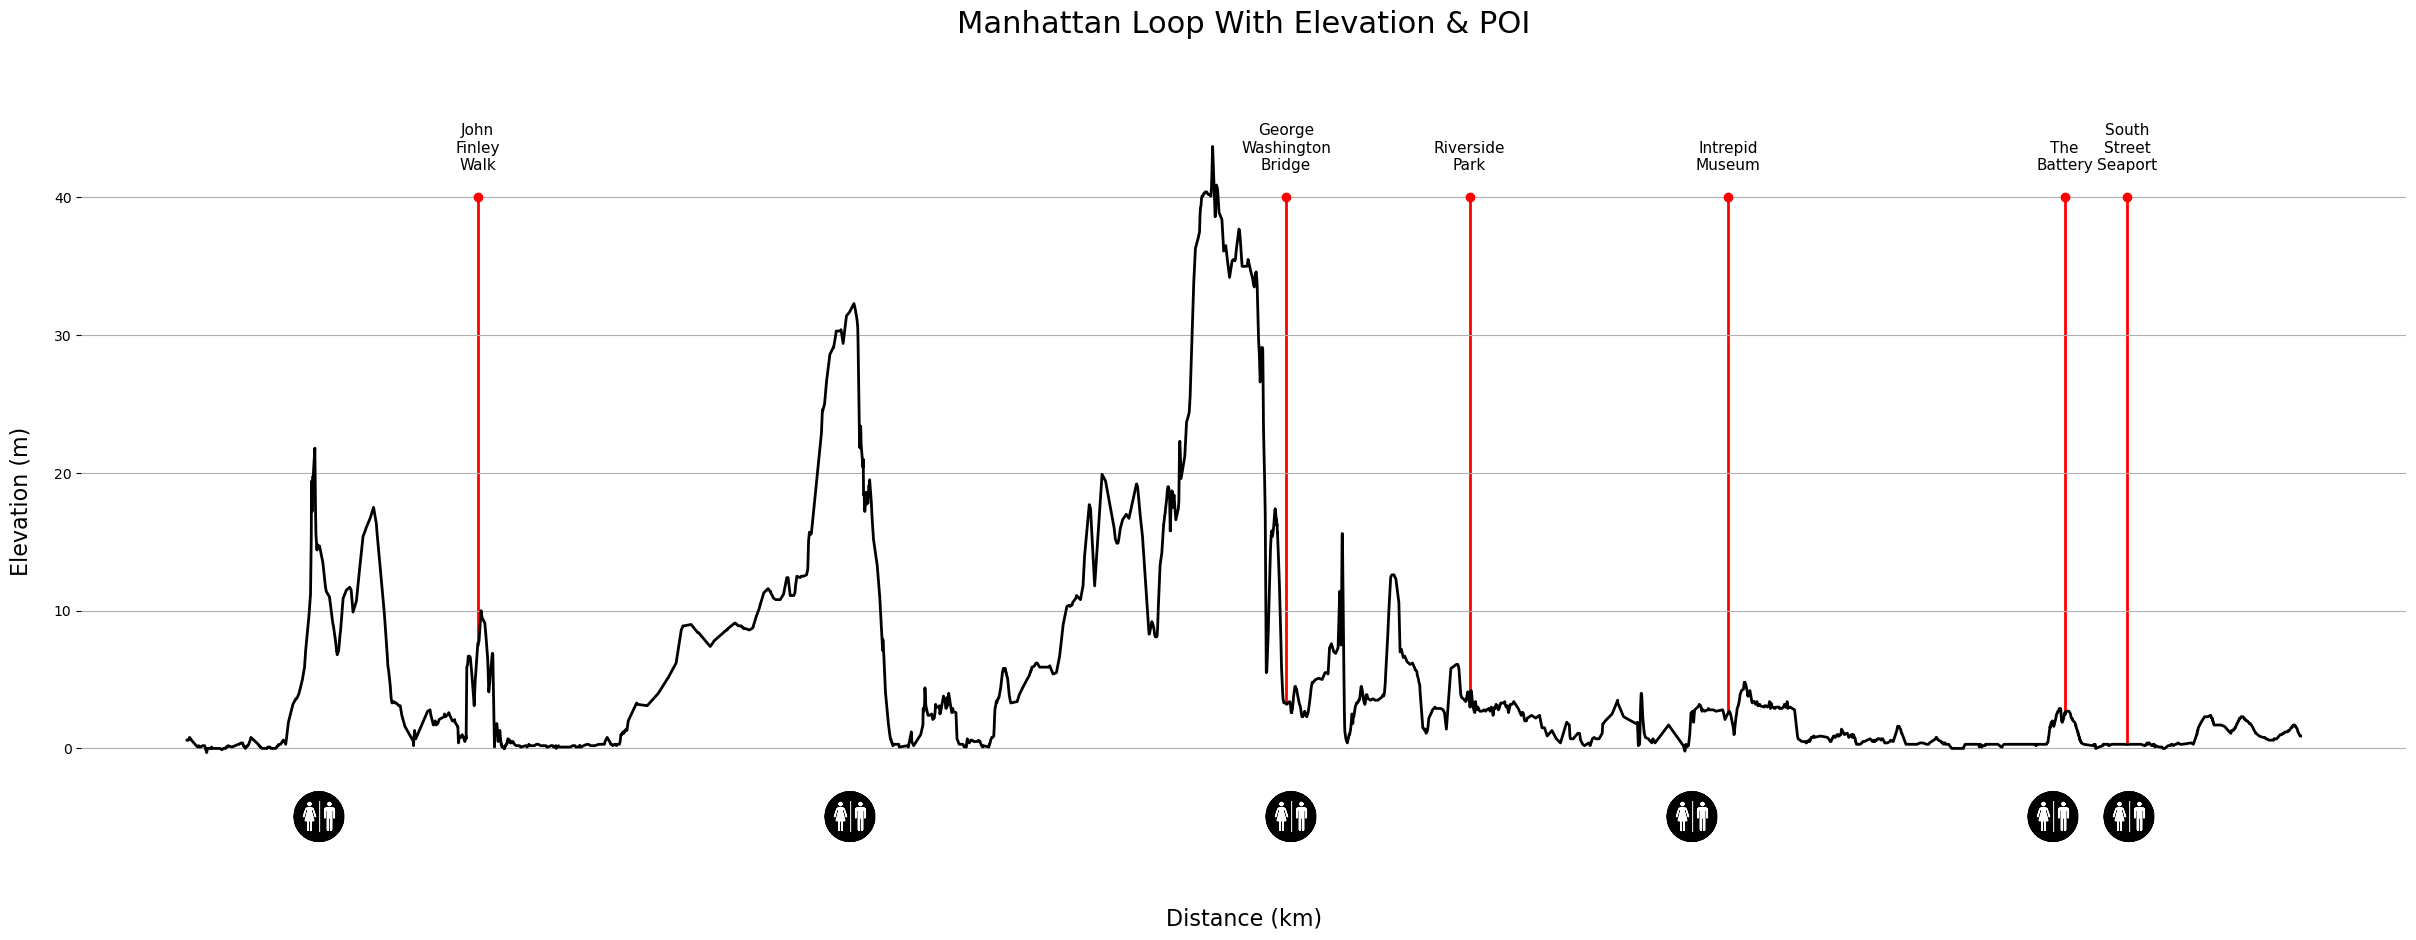

In [379]:
import pandas as pd
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image



# Load POIs
poi_df = pd.read_csv("poi_only.csv")
restroom_df = pd.read_csv("restrooms.csv")

# Load GPX file
with open("Manhattan_Loop.gpx", "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Extract track points
lats, lons, elevations, distances = [], [], [], []
distance = 0  # Cumulative distance

prev_point = None
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            elevations.append(point.elevation)

            if prev_point:
                # Calculate distance (approximate)
                delta_dist = np.sqrt((point.latitude - prev_point.latitude)**2 + (point.longitude - prev_point.longitude)**2)
                distance += delta_dist * 111  # Convert degrees to km
            distances.append(distance)
            prev_point = point

# Convert to NumPy array for fast searching
track_coords = np.column_stack((lats, lons))
track_tree = cKDTree(track_coords)

# Match POIs to nearest track points
poi_distances = []

for _, row in poi_df.iterrows():
    poi_coord = [row["Latitude"], row["Longitude"]]
    _, idx = track_tree.query(poi_coord)  # Find nearest GPX point
    poi_distances.append(distances[idx])

# Plot elevation profile
plt.figure(figsize=(30, 10))
plt.plot(distances, elevations, label="Route Elevation", color="black", linewidth=2, zorder=2)

# Set POIs at a fixed height of 25
poi_height = 40
plt.scatter(poi_distances, [poi_height] * len(poi_distances), color="red", zorder=3, label="POIs")

# Add labels above the POIs
for i, row in poi_df.iterrows():
    name_with_breaks = "\n".join(row["name"].split())  # Split and join with newline
    plt.annotate(name_with_breaks, (poi_distances[i], poi_height + 2), fontsize=11, ha="center")


# Match Restrooms to nearest track points
restroom_distances = []

for _, row in restroom_df.iterrows():
    restroom_coord = [row["Latitude"], row["Longitude"]]
    _, idx = track_tree.query(restroom_coord)  # Find nearest GPX point
    restroom_distances.append(distances[idx])


#Load Restoom Icon
image_path = "restroom_icon2.png"
restroom_icon = Image.open(image_path)
#Create Offset Image
imagebox = OffsetImage(restroom_icon, zoom=0.30) # Adjust zoom for desired size


for i, row in restroom_df.iterrows():
    ab = AnnotationBbox(imagebox, (restroom_distances[i], -5), frameon=False, xycoords='data', pad=0)
    plt.gca().add_artist(ab)   

ax = plt.gca()  # Get the current axis
for spine in ax.spines.values():
    spine.set_visible(False)

for i, row in poi_df.iterrows():
    # Get the x position of the POI and its height
    x_pos = poi_distances[i]
    y_pos = poi_height
    
    # Get the elevation at the current distance
    elevation_at_distance = elevations[distances.index(poi_distances[i])]
    
    # Calculate the line length as the difference between 40 and the elevation
    line_length = y_pos - elevation_at_distance
    
    # Plot the red line extending downward from the POI
    plt.plot([x_pos, x_pos], [y_pos, y_pos - line_length], color="red", lw=2, zorder=1)

# Labels & Styles
plt.ylim(bottom=-10)
plt.xticks([])
plt.yticks(range(0, 50, 10))
plt.xlabel("Distance (km)", labelpad=15, fontsize=16)
plt.ylabel("Elevation (m)", labelpad=15, fontsize=16)
plt.title("Manhattan Loop With Elevation & POI", pad=60, fontsize=22)
plt.grid(True)

# Show plot
plt.show()
